<a href="https://colab.research.google.com/github/CocoTheAussieCat/dl_at3/blob/master/Experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive Data Source

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Direct the workbook into the project folder

%cd drive/Shared\ drives/DL_AT3/Experimentation

/content/drive/Shared drives/DL_AT3/Experimentation


In [0]:
import os 
dataset_dir = os.getcwd() 

In [4]:
#Check the directory
dataset_dir

'/content/drive/Shared drives/DL_AT3/Experimentation'

In [5]:
#
!pwd

/content/drive/Shared drives/DL_AT3/Experimentation


In [6]:
#Check the files inside the directory
!ls

checkpoints		    Flicker8k_Dataset	      Flickr8k.token.txt
CrowdFlowerAnnotations.txt  Flickr8k_Dataset.zip      Flickr_8k.trainImages.txt
descriptions.txt	    Flickr_8k.devImages.txt   __MACOSX
Experimentation.ipynb	    Flickr8k.lemma.token.txt  model.png
ExpertAnnotations.txt	    Flickr_8k.testImages.txt  readme.txt
features_VGG16.pkl	    Flickr8k_text.zip


## Unzip File from Google Colab

In [0]:
#Unzip the Image Dataset
#!unzip Flickr8k_Dataset.zip

In [0]:
#Unzip the Text Dataset
#!unzip Flickr8k_text.zip

# Model

# Setup

Import libraries, set working directory and relative paths

In [8]:
import pandas as pd
import numpy as np
from numpy import argmax
import array as arr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from pickle import dump
from pickle import load
import string
import os
import time
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, Embedding, Dropout, Add

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
	
from keras.preprocessing.text import Tokenizer
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

Using TensorFlow backend.


In [0]:
# Set seeds for numpy and tensorflow
tf.random.set_seed(12)
np.random.seed(12)

In [10]:
# Check the folder's content after unziping 
!ls

checkpoints		    Flicker8k_Dataset	      Flickr8k.token.txt
CrowdFlowerAnnotations.txt  Flickr8k_Dataset.zip      Flickr_8k.trainImages.txt
descriptions.txt	    Flickr_8k.devImages.txt   __MACOSX
Experimentation.ipynb	    Flickr8k.lemma.token.txt  model.png
ExpertAnnotations.txt	    Flickr_8k.testImages.txt  readme.txt
features_VGG16.pkl	    Flickr8k_text.zip


In [0]:
# Set the dataset directory and relative directories
image_dir = dataset_dir + '/Flicker8k_Dataset'
caption_dir = dataset_dir + '/Flickr8k.token.txt'
train_dir = dataset_dir + '/Flickr_8k.trainImages.txt'
test_dir = dataset_dir + '/Flickr_8k.testImages.txt'
val_dir = dataset_dir + '/Flickr_8k.devImages.txt'


# Prepare image data

Extract image features

Code source: https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

Used VGG16 pre-trained model to extract image features by:

Loading VGG16 pre-trained model.
Removing top layer (because this layer is used for classification, which is not what is required)
Extract features from each image by using predict function of VGG16 model.
Create image_id by extracting the characters before .jpg in the file name.
Store these features as vector of length 4096 in dictionary with image_id as key.

# extract features from each photo in the directory
# Use VGG16 model, without top layer, add flatten and dense layer to get output of 4096
# which is the required shape for LSTM model
def extract_features(directory):
	# load the model
	model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

	model_new = tf.keras.Sequential([
  	model,
  	Flatten(),
	Dense(4096)])
	# remove top layer from model
	# model.layers.pop()
	# model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# print summary
	print(model_new.summary())
	# extract features from each photo
	features = dict() # create empty dictionary to store features in
	for name in os.listdir(directory):
		# load an image from file
		filename = directory + '/' + name
		image = load_img(filename, target_size=(224, 224))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape data for model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare image for VGG model
		image = preprocess_input(image)
		# get features
		feature = model_new.predict(image, verbose=0)
		# get image id
		image_id = name.split('.')[0]
		# store feature in dictionary using image_id as key
		features[image_id] = feature
		print('>%s' % name)
	return features

In [0]:
### ONLY RUN IF YOU DON'T HAVE features.pkl IN YOUR ENVIRONMENT
### TAKES >  1HOUR TO RUN
# Extract features from all images
#features = extract_features(image_dir)
#print('Extracted Features: %d' % len(features))

In [0]:
# Save feature as pickle file
#dump(features, open('features.pkl', 'wb'))

# Prepare text data

Code source: https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

Get cleaned caption for each image by:

Loading captions from text file.
Creating dictionary of captions using image_id as key.
Clean all captions by removing digits, single letter words (eg: a), punctuation and converting to lower case

In [0]:
# Load and read image description file
def load_doc(filename):
	"""
	Reads all captions from txt file as single string
	Inputs		- filename = filename of .txt with image captions
	Outputs		- text = string
	"""
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [0]:
# Extract descriptions for images
def load_descriptions(doc):
	"""
    Inputs      - doc = string, output from load_doc()
    Outputs     - mapping = dictionary-list of image_id and captions 
    """
	caption_dict = {}
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in caption_dict:
			caption_dict[image_id] = list()
			# store description
			caption_dict [image_id].append(image_desc)
	return caption_dict 

In [0]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

In [0]:
# Convert descriptions into vocabulary of words
def to_vocabulary(descriptions):
	# build list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

In [0]:
# Save descriptions to file, one image_id and description per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [17]:
# Load descriptions from tokenised text file
doc = load_doc(caption_dir)

# Create dictionary of image_id and descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

# Clean descriptions by stripping digits, punctuation, single letter words and converting to lowercase
clean_descriptions(descriptions)

# Create vocab from descriptions and get vocab length
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

# Save descriptions to file, one image_id and description per line
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 4473


# Load pre-processed training data for modelling

In [0]:
def load_doc(filename):
	# open file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close file
	file.close()
	return text

In [0]:
# Load pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

In [0]:
# Load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

In [0]:
# Load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = pickle.load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

## Tokenise descriptions
Map unique words to integers using tf.keras tokenizer

In [0]:
# Convert dictionary of clean descriptions to list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

In [0]:
# Fit tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = tf.keras.preprocessing.text.Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [0]:
# Create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each image identifier
	for key, desc_list in descriptions.items():
		# walk through each description for the image
		for desc in desc_list:
			# encode the sequence
			seq = tokenizer.texts_to_sequences([desc])[0]
			# split one sequence into multiple X,y pairs
			for i in range(1, len(seq)):
				# split into input and output pair
				in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				# encode output sequence
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				# store
				X1.append(photos[key][0])
				X2.append(in_seq)
				y.append(out_seq)
	return np.array(X1), np.array(X2), np.array(y)

In [0]:
# Helper function to calculate length of description with most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

## Load train and validation data for modelling
Images loaded as numpy arrays, descriptions tokenised

# Set training set sample size (default is set to 500 images)

In [0]:
# SET YOUR TRAINING SET SIZE
train_size = 500

In [42]:
# Load training set
train = random.sample(load_set(train_dir), train_size)

# Take a random sample of 800 pictures
#train = random.sample(train, 800)

print('Dataset: %d' % len(train))

# Load training set descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train = %d' % len(train_descriptions))

# Extract training set image features from features.pkl
train_features = load_photo_features('features_VGG16.pkl', train)
print('Photos: train = %d' % len(train_features))

# Prepare sequences of descriptions for train, test and validation sets
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# Determine max sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Dataset: 500
Descriptions: train = 500
Photos: train = 500
Vocabulary Size: 1069
Description Length: 26


In [0]:
# Create data for modelling
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

## Set validation set sample size (default is set to 100 images)

In [0]:
val_size = 100

In [50]:
# Load validation set (using devImages)
val = random.sample(load_set(val_dir), val_size)

print('Dataset: %d' % len(val))

# Load training set descriptions
val_descriptions = load_clean_descriptions('descriptions.txt', val)
print('Descriptions: val = %d' % len(val_descriptions))

# Extract training set image features from features.pkl
val_features = load_photo_features('features_VGG16.pkl', val)
print('Photos: val = %d' % len(val_features))

Dataset: 100
Descriptions: val = 100
Photos: val = 100


In [0]:
# Create data for modelling
X1val, X2val, yval = create_sequences(tokenizer, max_length, val_descriptions, val_features, vocab_size)

# Define model
Based on merge-model described by Tanti et al. in *Where to put the Image in an Image Caption Generator*

source: <https://arxiv.org/abs/1703.09137>

code source: https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

In [0]:
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = Add()([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	optimizer = tf.keras.optimizers.Adam(0.01)
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['accuracy'])
	# summary
	print(model.summary())
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

# Train model
Use checkpoint callbacks to save training informatoin

In [0]:
# Create base model
model = define_model(vocab_size, max_length)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 256)      985088      input_6[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 4096)         0           input_5[0][0]                    
____________________________________________________________________________________________

In [0]:
#### MAKE A DIRECTORY TO SAVE CHECKPOINTS TO ###
# eg: check_path = 'checkpoints/rebecca/exp_2'
###########################################################################


check_path = 'checkpoints/rebecca/exp_2' # CHANGE THIS
!mkdir -p $check_path

#################################################################
check_dir = check_path+'/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

# Monitor validation loss, saving only the best, stopping early if no improvement after 5 epochs, dropping learning rate if loss plateaux
checkpoint = ModelCheckpoint(check_dir, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.005)

In [0]:
# Fit model
tic = time.perf_counter()
history = model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, 
                    validation_data=([X1val, X2val], yval), 
                    callbacks = [checkpoint, early_stopping, reduce_lr],
                    )
toc = time.perf_counter()
run_time = (toc-tic)/60
print(f'Model ran in: {run_time:0.2f} minutes')

Epoch 1/20

Epoch 00001: val_loss improved from inf to 5.55120, saving model to checkpoints/rebecca/exp_2/model-ep001-loss6.098-val_loss5.551.h5
1916/1916 - 399s - loss: 6.0981 - accuracy: 0.0969 - val_loss: 5.5512 - val_accuracy: 0.0991 - lr: 0.0100
Epoch 2/20

Epoch 00002: val_loss improved from 5.55120 to 5.53920, saving model to checkpoints/rebecca/exp_2/model-ep002-loss5.700-val_loss5.539.h5
1916/1916 - 393s - loss: 5.7004 - accuracy: 0.0979 - val_loss: 5.5392 - val_accuracy: 0.0991 - lr: 0.0100
Epoch 3/20


KeyboardInterrupt: ignored

## Plot accuracy and loss of training and validation

In [0]:
def modelPlot(history_name, plt_title):
    """
    Generates plot (with title) for model training and validation accuracy and loss by epoch
    Inputs  - history_name = history object resulting from fitted model
            - plt_title = title for plot, as string

    Output  - plot
    """

    accuracy_filename = check_dir+'/acc.png'
    loss_filename = check_dir+'/loss.png'

    plt.plot(trained_model.history['accuracy'], label='Training', color = 'purple')
    plt.plot(trained_model.history['val_accuracy'], label='Validation', color = 'orange')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title(plt_title)
    plt.legend()
    plt.savefig(accuracy_filename)

    plt.plot(history_name.history['loss'], label='Training', color = 'blue')
    plt.plot(history_name.history['val_loss'], label='Validation', color = 'orange')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title(plt_title)
    plt.legend()
    plt.savefig(loss_filename)

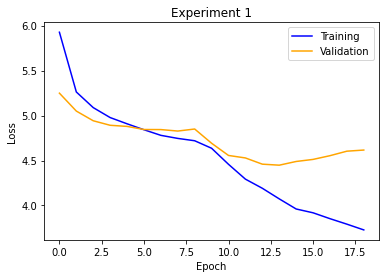

In [0]:
modelPlot(history, 'Experiment 1')


In [0]:
from matplotlib.pyplot import savefig

# Evaluate model

In [0]:
# Reverse vectorisation of words to map integers back to words
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [0]:
# Generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed generation process
	in_text = 'startseq'
	# iterate over whole length of sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

In [0]:
# Evaluate model by predicting captions for images
# Compare predicted captions to truth captions
# Calculate BLEU-1 through BLEU-4 to determine model fit
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [0]:
### FIND YOUR BEST MODEL FROM THE MODEL.FIT OUTPUT AND COPY THE NAME BELOW #######
# Get best model filename from model.fit output
checkpoint_best_model = 'checkpoints/rebecca/exp_1/model-ep014-loss4.074-val_loss4.448.h5' # CHANGE THIS

# Load best model
best_model = tf.keras.models.load_model(checkpoint_best_model)


In [0]:
tic = time.perf_counter()
evaluate_model(best_model, val_descriptions, val_features, tokenizer, max_length)
toc = time.perf_counter()
run_time = (toc-tic)/60
print(f'Model ran in: {run_time:0.4f} minutes')

BLEU-1: 0.312347
BLEU-2: 0.104778
BLEU-3: 0.061958
BLEU-4: 0.014870
Model ran in: 6.4194 minutes
